In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.raw_data = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_val = None
        self.x_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.raw_data = self.data[['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'size_category']]

    def preprocess_data(self):
        self.load_data()

        self.x = self.data.drop(['month', 'day', 'size_category'], axis=1)
        self.y = self.data['size_category']

        le = LabelEncoder()
        self.y = le.fit_transform(self.y)

        # Splitting data into training, validation, and test sets
        x_temp, self.x_test, y_temp, self.y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=42)
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

        return self.x_train, self.x_val, self.x_test, self.y_train, self.y_val, self.y_test

    # def plot_univariate_analysis(self):
    #     df = pd.DataFrame()
    #     df['small'] = self.raw_data[self.raw_data['size_category'] == 'small']['month'].value_counts()
    #     df['large'] = self.raw_data[self.raw_data['size_category'] == 'large']['month'].value_counts()

    #     df['small_percentage'] = self.raw_data[self.raw_data['size_category'] == 'small']['month'].value_counts(normalize=True)
    #     df['large_percentage'] = self.raw_data[self.raw_data['size_category'] == 'large']['month'].value_counts(normalize=True)




In [25]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_shape=(input_shape,)),
            # tf.keras.layers.Dense(units=64, activation='relu'),
            # tf.keras.layers.Dense(units=96, activation='relu'),
            # tf.keras.layers.Dense(units=32, activation='relu'),
            # tf.keras.layers.Dense(units=64, activation='relu'),
            # tf.keras.layers.Dense(units=96, activation='relu'),
            # tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            # tf.keras.layers.Dense(Dropout(rate=0.5)),
            tf.keras.layers.Dense(units=96, activation='relu'),
            # tf.keras.layers.Dense(Dropout(rate=0.5)),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [26]:
# Usage of the DataPreprocessor class
file_path = "forestfires.csv"
preprocessor = DataPreprocessor(file_path)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess_data()

In [27]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [28]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((309, 28), (104, 28), (104, 28), (309,))

In [30]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
10/10 [==============================] - 1s 28ms/step - loss: 51.8056 - accuracy: 0.6052 - val_loss: 0.6964 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 2/50
10/10 [==============================] - 0s 15ms/step - loss: 0.6952 - accuracy: 0.7282 - val_loss: 0.6688 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 3/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6704 - accuracy: 0.7282 - val_loss: 0.6703 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 4/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6352 - accuracy: 0.7314 - val_loss: 0.6659 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6273 - accuracy: 0.7314 - val_loss: 0.6534 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 6/50
10/10 [==============================] - 0s 14ms/step - loss: 0.6175 - accuracy: 0.7379 - val_loss: 0.6481 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 7/50
10/10 [====================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 30ms/step - loss: 58.3192 - accuracy: 0.6311 - val_loss: 0.6229 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6717 - accuracy: 0.7282 - val_loss: 41.0329 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 6.3260 - accuracy: 0.7282 - val_loss: 0.5916 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.6026 - accuracy: 0.7282 - val_loss: 0.5754 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.5978 - accuracy: 0.7282 - val_loss: 0.5783 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 6/50
10/10 [==============================] - 0s 13ms/step - loss: 0.5940 - accuracy: 0.7282 - val_loss: 0.5730 - val_accuracy: 0.7404 - lr: 0.0100
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.5923 - acc

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 38ms/step - loss: 4.8070 - accuracy: 0.5663 - val_loss: 3.1554 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 20ms/step - loss: 1.4287 - accuracy: 0.7217 - val_loss: 0.5307 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 18ms/step - loss: 1.4348 - accuracy: 0.7023 - val_loss: 1.0551 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 17ms/step - loss: 1.6994 - accuracy: 0.6828 - val_loss: 1.3416 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 17ms/step - loss: 1.4888 - accuracy: 0.6958 - val_loss: 0.8573 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 0.5399 - accuracy: 0.7799 - val_loss: 1.0660 - val_accuracy: 0.7788 - lr: 5.0000e-04
Epoch 7/50
10/10 [==============================] - 0s 17ms/step - loss: 0.6821 - a

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 26ms/step - loss: 10.4069 - accuracy: 0.6181 - val_loss: 1.7383 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 2.2266 - accuracy: 0.7152 - val_loss: 0.8746 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.9202 - accuracy: 0.6699 - val_loss: 1.0990 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.7285 - accuracy: 0.7735 - val_loss: 0.4960 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.4789 - accuracy: 0.8091 - val_loss: 0.3611 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 13ms/step - loss: 0.2697 - accuracy: 0.8900 - val_loss: 0.3009 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 7/50
10/10 [==============================] - 0s 14ms/step - loss: 0.2276 - accu

In [31]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.7500, Precision - 0.8137, Recall - 0.7500, F1-score - 0.6599, Convergence Speed - 50 epochs, Training Time - 7.28 seconds
SGD_momentum: Test Accuracy - 0.7308, Precision - 0.5340, Recall - 0.7308, F1-score - 0.6171, Convergence Speed - 18 epochs, Training Time - 2.90 seconds
Nesterov: Test Accuracy - 0.7308, Precision - 0.5340, Recall - 0.7308, F1-score - 0.6171, Convergence Speed - 26 epochs, Training Time - 4.15 seconds
RMSprop: Test Accuracy - 0.9231, Precision - 0.9254, Recall - 0.9231, F1-score - 0.9199, Convergence Speed - 50 epochs, Training Time - 8.97 seconds
Adagrad: Test Accuracy - 0.8558, Precision - 0.8591, Recall - 0.8558, F1-score - 0.8430, Convergence Speed - 50 epochs, Training Time - 7.38 seconds
Adadelta: Test Accuracy - 0.7308, Precision - 0.5340, Recall - 0.7308, F1-score - 0.6171, Convergence Speed - 50 epochs, Training Time - 7.53 seconds
Adam: Test Accuracy - 0.9423, Precision - 0.9423, Recall - 0.9423, F1-score - 0.9423, Converg

In [32]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Burned Forest Fires"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Burned Forest Fires,309,28,int32,FNN,SGD,0.750000,0.813725,0.750000,0.659925,50,7.281615,51.805637,0.696397
1,Burned Forest Fires,309,28,int32,FNN,SGD_momentum,0.730769,0.534024,0.730769,0.617094,18,2.900823,36.371250,0.608725
2,Burned Forest Fires,309,28,int32,FNN,Nesterov,0.730769,0.534024,0.730769,0.617094,26,4.152228,58.319168,0.622863
3,Burned Forest Fires,309,28,int32,FNN,RMSprop,0.923077,0.925379,0.923077,0.919922,50,8.966100,4.806965,3.155367
4,Burned Forest Fires,309,28,int32,FNN,Adagrad,0.855769,0.859130,0.855769,0.843008,50,7.382399,1.941499,0.712320
5,Burned Forest Fires,309,28,int32,FNN,Adadelta,0.730769,0.534024,0.730769,0.617094,50,7.530918,9.745149,8.382270
6,Burned Forest Fires,309,28,int32,FNN,Adam,0.942308,0.942308,0.942308,0.942308,50,6.770259,10.406874,1.738334
7,Burned Forest Fires,309,28,int32,FNN,AMSGrad,0.942308,0.946529,0.942308,0.939942,50,7.686388,5.132452,3.150920
8,Burned Forest Fires,309,28,int32,FNN,AdamW,0.903846,0.908242,0.903846,0.898237,50,7.503209,5.593300,3.177383
9,Burned Forest Fires,309,28,int32,FNN,Yogi,0.980769,0.982051,0.980769,0.980973,42,7.741271,9.281899,5.087839


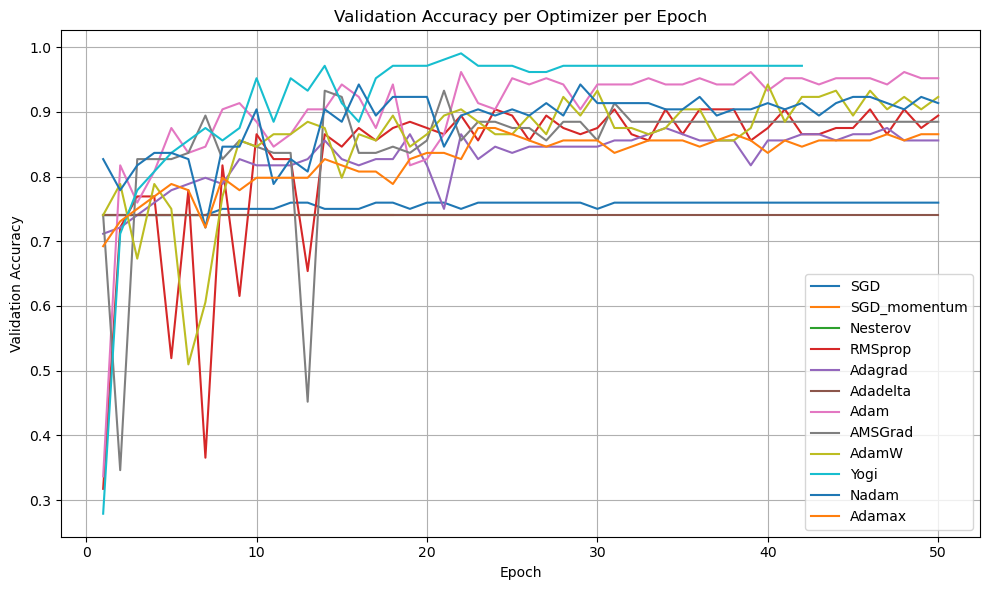

In [33]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


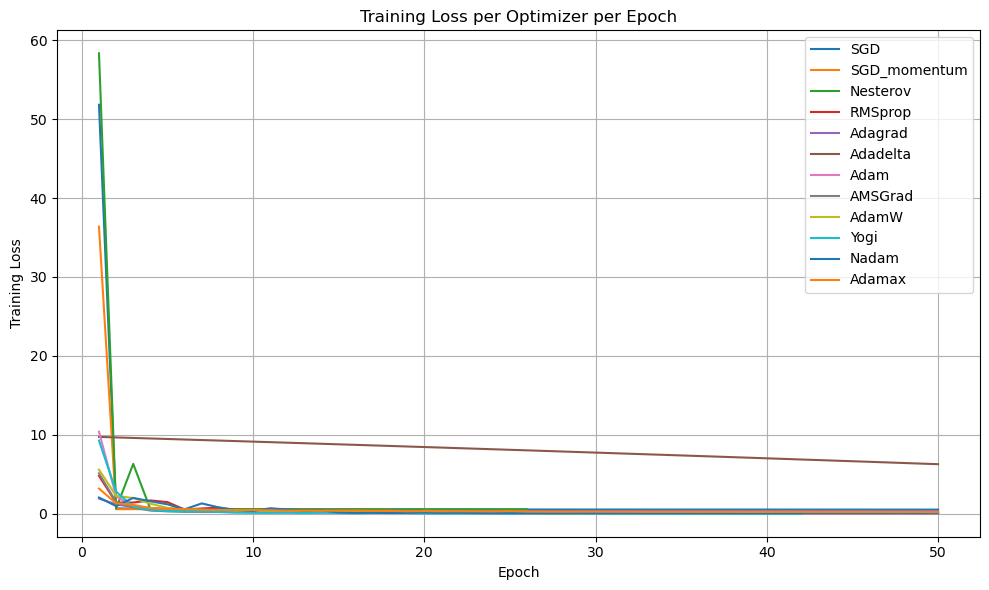

In [34]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
final_df.to_csv('BURNED AREA OF FOREST FIRES_nn_r(3).csv', index=False)

#############  Before Presentation #########################################

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression  
import time
import tensorflow as tf

In [2]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.raw_data = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.raw_data = self.data[['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'size_category']]

    def preprocess_data(self):
        self.load_data()

        self.x = self.data.drop(['month', 'day', 'size_category'], axis=1)
        self.y = self.data['size_category']

        le = LabelEncoder()
        self.y = le.fit_transform(self.y)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=9)

    def plot_univariate_analysis(self):
        df = pd.DataFrame()
        df['small'] = self.raw_data[self.raw_data['size_category'] == 'small']['month'].value_counts()
        df['large'] = self.raw_data[self.raw_data['size_category'] == 'large']['month'].value_counts()

        df['small_percentage'] = self.raw_data[self.raw_data['size_category'] == 'small']['month'].value_counts(normalize=True)
        df['large_percentage'] = self.raw_data[self.raw_data['size_category'] == 'large']['month'].value_counts(normalize=True)


In [3]:
class NeuralNetwork:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, epochs=100, batch_size=20, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=-1)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [4]:
# Initialize the data preprocessor
preprocessor = DataPreprocessor('forestfires.csv')

# Preprocess the data
preprocessor.preprocess_data()


Training model with SGD optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================] - 0s 7ms/step - loss: 0.6298 - accuracy: 0.7308
Training model with Adam optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================] - 0s 6ms/step - loss: 0.5620 - accuracy: 0.7244
Training model with RMSprop optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================] - 0s 6ms/step - loss: 0.6320 - accuracy: 0.7179
Training model with Adagrad optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================] - 0s 6ms/step - loss: 0.6414 - accuracy: 0.7115
Training model with Adadelta optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================] - 0s 4ms/step - loss: 0.7415 - accuracy: 0.7115
Training model with Adamax optimizer...
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
5/5 [==============================]

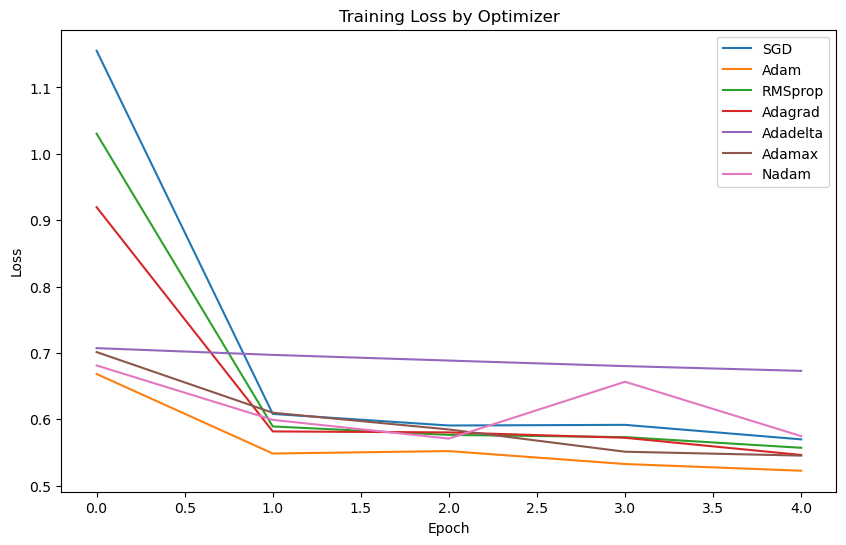

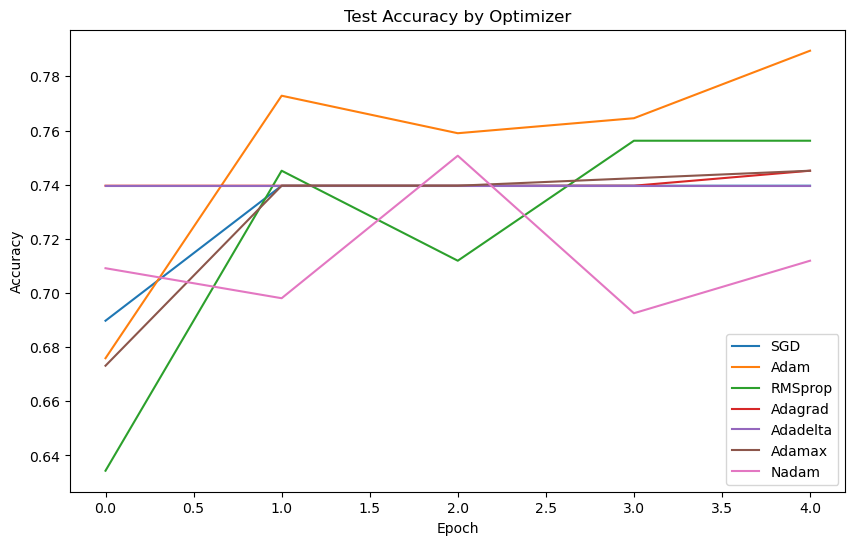

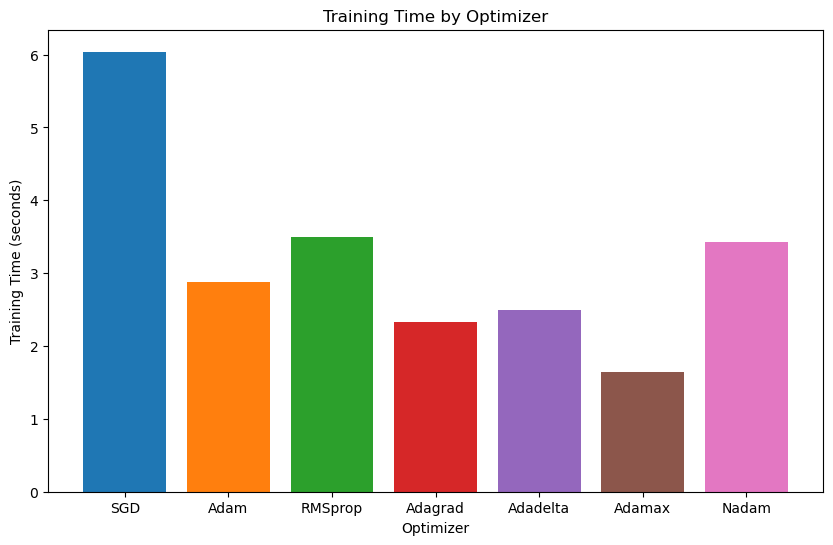

In [5]:
# List of optimizers to test for NN
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetwork()
    model_instance.build_ann(preprocessor.x_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(preprocessor.x_train, preprocessor.y_train, epochs=5, batch_size=32, validation_data=(preprocessor.x_test, preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(preprocessor.x_test, preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [6]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adamax
Accuracy: 0.7628
Loss: 0.5453
Shortest Training Time: 1.65 seconds


Comparison of Optimizers:
          accuracy      loss  training_time
SGD       0.730769  0.569812       6.038533
Adam      0.724359  0.522554       2.879548
RMSprop   0.717949  0.557129       3.497428
Adagrad   0.711538  0.546288       2.327403
Adadelta  0.711538  0.672985       2.492467
Adamax    0.762821  0.545336       1.646309
Nadam     0.717949  0.574647       3.421966


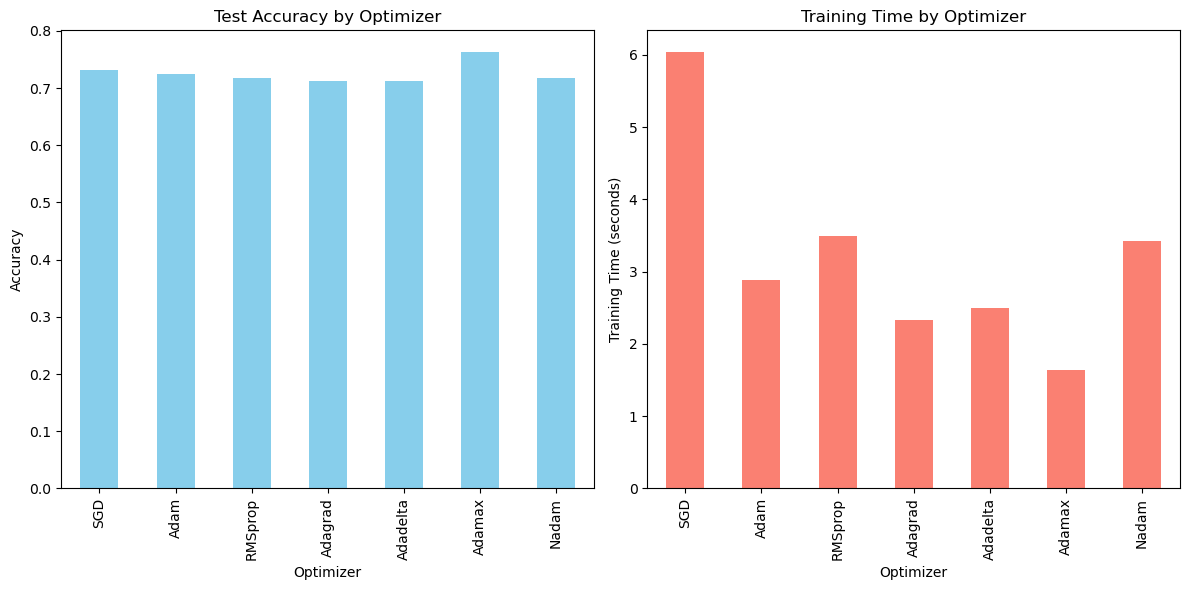

In [7]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression  
import tensorflow_addons as tfa
import time

In [4]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.raw_data = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        self.raw_data = self.data[['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'size_category']]

    def preprocess_data(self):
        self.load_data()

        self.x = self.data.drop(['month', 'day', 'size_category'], axis=1)
        self.y = self.data['size_category']

        le = LabelEncoder()
        self.y = le.fit_transform(self.y)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=9)


In [5]:
class NeuralNetwork:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=96, activation='relu'),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, epochs=100, batch_size=20, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=-1)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [6]:
# Initialize the data preprocessor
preprocessor = DataPreprocessor('forestfires.csv')

# Preprocess the data
preprocessor.preprocess_data()


Training model with SGD optimizer...
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/1

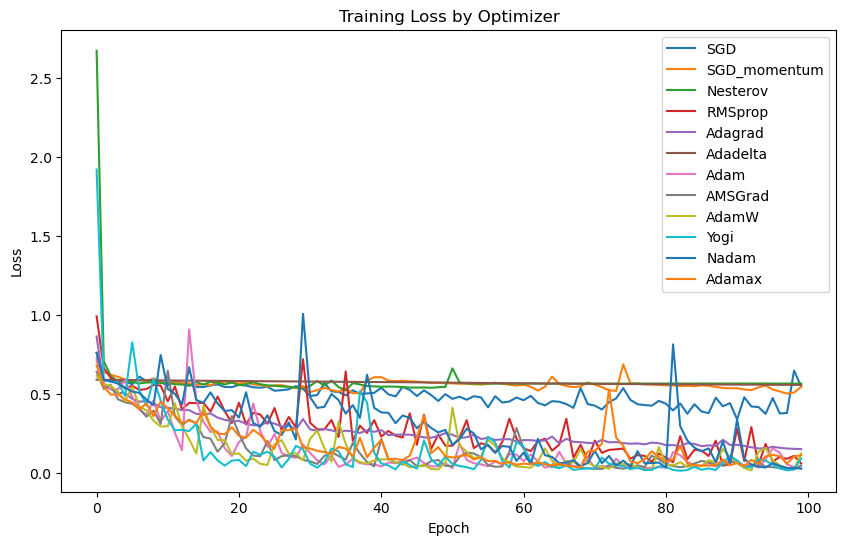

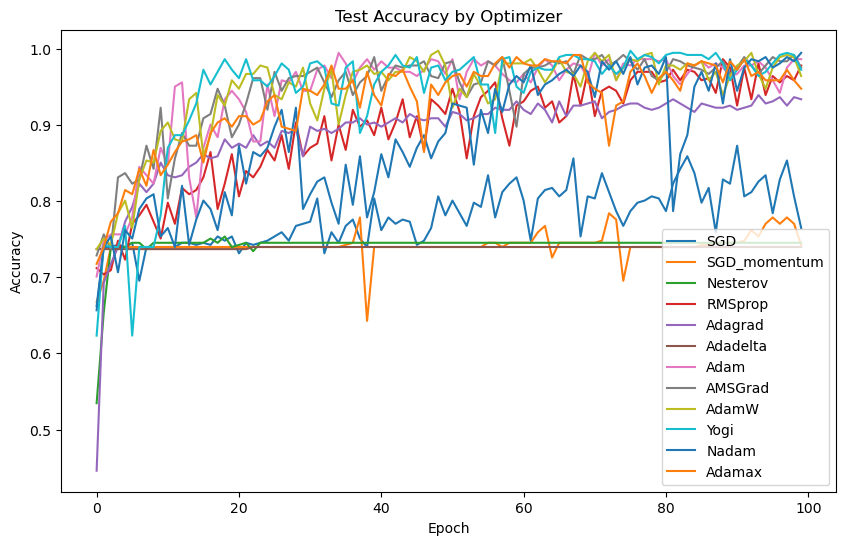

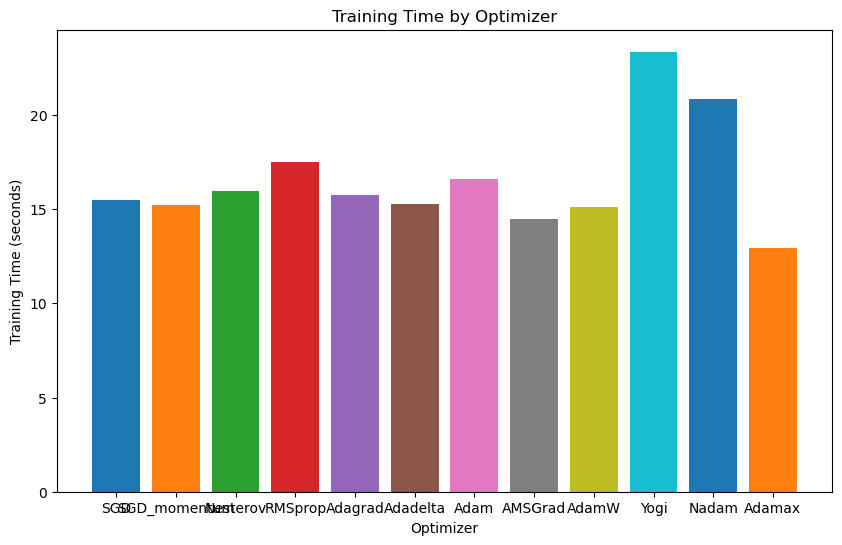

In [14]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetwork()
    model_instance.build_ann(preprocessor.x_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = model_instance.train(preprocessor.x_train, preprocessor.y_train, epochs=100, batch_size=32, validation_data=(preprocessor.x_test, preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(preprocessor.x_test, preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [17]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adamax
Accuracy: 0.9872
Loss: 0.1140
Shortest Training Time: 12.94 seconds


Comparison of Optimizers:
              accuracy      loss  training_time
SGD           0.756410  0.546474      15.491113
SGD_momentum  0.730769  0.545267      15.226005
Nesterov      0.717949  0.566549      15.960666
RMSprop       0.923077  0.061734      17.519215
Adagrad       0.948718  0.151930      15.755040
Adadelta      0.711538  0.557508      15.294573
Adam          0.980769  0.030109      16.602541
AMSGrad       0.980769  0.048675      14.489903
AdamW         0.891026  0.124407      15.106665
Yogi          0.974359  0.093328      23.362321
Nadam         0.967949  0.028364      20.869794
Adamax        0.987179  0.113958      12.937506


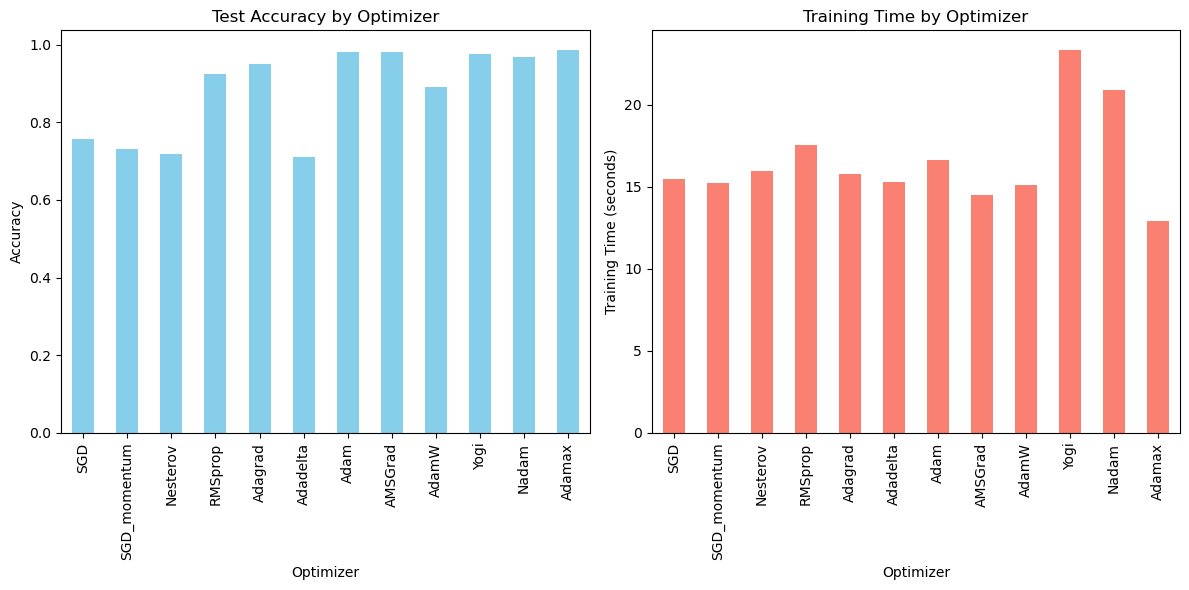

In [18]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()
